In [1]:
#Transformer模型

In [26]:
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import copy

In [27]:
#embed = nn.Embedding(100,3,padding_idx = 0)#补齐 等于什么相同数字部分都会变成0
#input = torch.tensor([[1,4,5,9,0],[2,3,4,99,0]])
#print(embed(input).shape)
#print(embed(input))

In [28]:
#文本嵌入层 将文本变成向量
class Embeddings(nn.Module):
    def __init__(self,d_model,vocab):
        super().__init__()
        self.vocab = vocab #词典的大小
        self.d_model = d_model#词嵌入维度的大小
        #定义embedding层
        self.embed = nn.Embedding(vocab,d_model)
    def forward(self,x):
        #x[batch_size,seq——len]
        embed_x = self.embed(x)
        #embed_x乘根号下d_model
        #符合标准分布 增加影响
        return embed_x*math.sqrt(self.d_model)
my_embed = Embeddings(vocab = 1000,d_model = 512)
x = torch.tensor([[1,4,7,10],[2,6,4,15]])
result = my_embed(x)
print(result.shape)
print(result)

torch.Size([2, 4, 512])
tensor([[[ -6.7544,  37.2969, -24.1185,  ..., -28.1623, -16.5913, -33.1305],
         [-30.0487,  -0.6622,   1.8885,  ..., -21.5260, -10.0797,  25.3691],
         [-20.4045,  28.2031, -26.1684,  ...,   7.6636, -15.9720, -11.5723],
         [ -6.0887,  -8.3745,  28.9567,  ...,  28.7766,   8.4879,   7.3830]],

        [[-16.3278, -45.5139, -19.5662,  ..., -25.9620,  -1.0796,  15.6002],
         [ 11.5280,  11.2595, -17.6959,  ...,  31.9375, -23.2782,  12.1726],
         [-30.0487,  -0.6622,   1.8885,  ..., -21.5260, -10.0797,  25.3691],
         [ -4.7491, -19.5547,   0.9225,  ...,  -0.5921, -45.5901,   6.4347]]],
       grad_fn=<MulBackward0>)


In [29]:
#位置编码器层 - 1 1  周期性函数  
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len = 60):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p = dropout)
        pe = torch.zeros(max_len,d_model)
        #定义位置矩阵【max_len,1】
        tem_vec = torch.arange(0,max_len).unsqueeze(1)
        #根据公式定义矩阵[256]
        div_vec = torch.exp(torch.arange(0,d_model,2)*-math.log(10000.0)/d_model)
        #将每个位置先赋值256个向量值
        position = tem_vec*div_vec#【60，256】
        #pe进行复制
        pe[:,0::2] = torch.sin(position)
        pe[:,1::2] = torch.cos(position)
        pe = pe.unsqueeze(0)
        #print(pe.shape)
        #[1,60,512]
        return self.register_buffer('pe',pe)#缓存区
    def forward(self,x):
        #x[batch_size,seq_len,512]
        #[2,4,512] [1,4,512]
        position_x = x + self.pe[:,:x.shape[1]]#广播模式相加
        return self.dropout(position_x)
my_embed = Embeddings(vocab = 1000,d_model = 512)
x = torch.tensor([[1,4,7,10],[2,6,4,15]])
result = my_embed(x)
print(result.shape)
position = PositionalEncoding(d_model = 512,dropout = 0.1)
result1 = position(result)
print(result1.shape)
print(result1)

torch.Size([2, 4, 512])
torch.Size([2, 4, 512])
tensor([[[ -7.5525, -18.9474, -37.2853,  ..., -11.1343,  34.7322,  22.2318],
         [  9.7805,  -0.0000,  21.4542,  ...,  10.8125,  43.6190, -44.4165],
         [-57.4526,  -2.5568,  27.6427,  ...,  38.0741,   0.0000,  -8.3495],
         [  9.5816,  -0.0000,  30.8390,  ...,  13.5146, -11.5469,  -3.8992]],

        [[ 28.0561,  10.0861, -20.4307,  ...,  -5.9435,  13.0939, -29.4111],
         [ 10.0089,  13.3344,  22.0202,  ..., -43.2721,   2.9262,  -6.1910],
         [  9.8558,  -1.9507,  21.5815,  ...,  10.8125,  43.6191, -44.4165],
         [  9.0348,  -8.0585,  46.9195,  ...,   0.0000,   0.0000, -46.2937]]],
       grad_fn=<MulBackward0>)


In [30]:
#掩码张量 掩盖未来的信息防止被提前看到
#生成下三角矩阵
b = torch.ones((5,5),dtype = torch.long)
print(1 - torch.triu(b))

tensor([[0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0]])


tensor([[1.5000, 2.0000, 3.6000],
        [3.5000, 2.5000, 3.6000],
        [2.5000, 8.2000, 4.3000]])


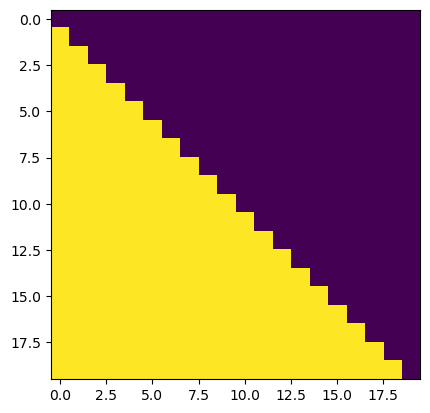

In [31]:
import matplotlib.pyplot as plt
a = torch.tensor([[1.5,2.0,3.6],[3.5,2.5,3.6],[2.5,8.2,4.3]])
b = torch.ones((20,20),dtype = torch.long)
mask = 1 - torch.triu(b)
#a.masked_fill_(mask == 0,10000)#mask为0的位置对应a出用后面的值进行取代 可以赋值为负无穷经过softmax
print(a)
plt.figure()
plt.imshow(mask)
plt.show()

In [32]:
def sub_mask(size):
    b = torch.ones((1,size,size),dtype = torch.long)
    return 1-torch.triu(b,diagonal = 1)
#生成下三角矩阵
#注意力机制
def attention(query,key,value,mask = None,dropout = None):
    #三个相等【2，4，512】
    #获取dk
    d_k = query.size()[-1]
    #变换后为【2，4，4】
    scores = torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)
    #如果mask不为孔 需要对分数进行掩码
    if mask is not None:
        scores = scores.masked_fill_(mask == 0,-1e9)
    #归一化
    atten_weights = F.softmax(scores,dim = -1)
    #print(atten_weights)
    if dropout is not None:
        atten_weights = dropout(atten_weights)
    return torch.matmul(atten_weights,value),atten_weights

In [33]:
#测试
def atten_test():
    vocab = 1000
    d_model = 512
    x = torch.tensor([[1,2,3,10],[2,5,25,6]])
    my_embed = Embeddings(vocab=vocab,d_model=d_model)
    embed_x = my_embed(x)
    print(embed_x.shape)
    #位置编码器层
    dropout_p = 0.1
    my_pe = PositionalEncoding(d_model = d_model,dropout = dropout_p)
    position = my_pe(embed_x)
    #子注意力机制
    query = value = key = position
    #atten_result,atten_weights = attention(query,key,value)
    #print(atten_result.shape)
    #print(atten_weights.shape)
    #假如加入掩码
    mask = torch.zeros(([2,4,4]))
    atten_result,atten_weights = attention(query,key,value,mask = mask)
atten_test()

torch.Size([2, 4, 512])


In [56]:
#多头注意力机制
def clones(module,N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
class MultiHeadedAttention(nn.Module):
    def __init__(self,embed_dim,head,dropout_p):
        super().__init__()
        #确保整除
        assert embed_dim%head == 0
        #获取每个头的词嵌入维度
        self.d_k = embed_dim // head
        self.head = head
        #定义四个全连接层
        self.linears = clones(module = nn.Linear(embed_dim,embed_dim),N = 4)
        self.atten_weight = None
        #定义dropout
        self.dropout = nn.Dropout(p = dropout_p)
    def forward(self,query,key,value,mask = None):#qkv【2，4，512】
        #mask[head,seq_len,seq_len][8,4,4]
        if mask is not None:
            mask = mask.unsqueeze(0)#[1,8,4,4]
        batch_size = query.size()[0]
        #三个参数都要经过linear层【2，8，4，64】
        query,key,value = [model(x).view(batch_size,-1,self.head,self.d_k).transpose(1,2) for model,x in zip(self.linears,(query,key,value))]
        #atten_weight[2,8,4,4]  *[2,8,4,64]--- x[2,8,4,64]
        x,atten_weight = attention(query,key,value,mask = mask,dropout = self.dropout) 
        x = x.transpose(1,2).contiguous().view(batch_size, -1, self.head*self.d_k)
        return self.linears[-1](x)
#MultiHeadedAttention(embed_dim = 512,head = 8,dropout_p = 0.1 )

In [35]:
def mulatten_test():
    vocab = 1000
    d_model = 512
    x = torch.tensor([[1,2,3,10],[2,5,25,6]])
    my_embed = Embeddings(vocab=vocab,d_model=d_model)
    embed_x = my_embed(x)
    print(embed_x.shape)
    #位置编码器层
    dropout_p = 0.1
    my_pe = PositionalEncoding(d_model = d_model,dropout = dropout_p)
    position = my_pe(embed_x)
    #子注意力机制
    query = value = key = position
    #实例化多头注意力机制的对象
    mha = MultiHeadedAttention(embed_dim = 512,head = 8,dropout_p = 0.1 )
    #atten_result,atten_weights = attention(query,key,value)
    #print(atten_result.shape)
    #print(atten_weights.shape)
    #假如加入掩码
    mask = torch.zeros(8,4,4)
    atten_result = mha(query,key,value,mask = mask)
    print(atten_result.shape)
    print(atten_result)
mulatten_test()

torch.Size([2, 4, 512])
torch.Size([2, 4, 512])
tensor([[[11.8092,  4.2623,  5.0701,  ..., -1.8925,  6.0733,  3.8997],
         [10.4560,  7.4084,  5.9079,  ..., -1.2302,  6.4411,  5.9858],
         [ 7.8284,  4.6580,  5.0052,  ..., -1.2747,  2.3641,  3.4647],
         [ 7.6787,  6.0714,  6.6178,  ..., -2.0894,  6.2263,  3.6953]],

        [[ 2.7854,  0.5934,  1.5577,  ..., -0.4511,  5.1985,  6.7118],
         [ 0.1875,  4.4717,  6.6285,  ...,  0.8038,  4.6550,  4.2542],
         [ 4.4418,  1.9698,  1.7667,  ...,  2.0101,  6.0259,  7.6964],
         [ 3.1796,  4.7967,  4.8866,  ...,  1.6901,  4.3945,  6.0396]]],
       grad_fn=<ViewBackward0>)


In [36]:
#前馈全连接层
#怕拟合程度不够
class PositionwiseFeedForward(nn.Module):
    def __init__(self,d_model,d_ff,dropout = 0.1):
        super().__init__()
        #d_model 词嵌入维度
        #d_ff前馈全连接层内部维度
        self.linear1 = nn.Linear(d_model,d_ff)
        self.linear2 = nn.Linear(d_ff,d_model)
        self.dropout = nn.Dropout(p = dropout)
    def forward(self,x):
        #来自多头注意力机制的结果
        return self.linear2(self.dropout(F.relu(self.linear1(x))))


In [37]:
#前馈验证
def mulatten_test1():
    vocab = 1000
    d_model = 512
    x = torch.tensor([[1,2,3,10],[2,5,25,6]])
    my_embed = Embeddings(vocab=vocab,d_model=d_model)
    embed_x = my_embed(x)
    print(embed_x.shape)
    #位置编码器层
    dropout_p = 0.1
    my_pe = PositionalEncoding(d_model = d_model,dropout = dropout_p)
    position = my_pe(embed_x)
    #子注意力机制
    query = value = key = position
    #实例化多头注意力机制的对象
    mha = MultiHeadedAttention(embed_dim = 512,head = 8,dropout_p = 0.1 )
    #atten_result,atten_weights = attention(query,key,value)
    #print(atten_result.shape)
    #print(atten_weights.shape)
    #假如加入掩码
    mask = torch.zeros(8,4,4)
    atten_result = mha(query,key,value,mask = mask)
    FF = PositionwiseFeedForward(d_model = 512,d_ff = 1024)
    dd = FF(atten_result)
    print(dd)
    print(dd.shape)
#mulatten_test1()

In [71]:
#规范化NORM  参数可能出现过大过小
class LayerNorm(nn.Module):
    def __init__(self,features,eps = 1e-6):
        #features词嵌入维度
        super().__init__()
        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    def forward(self,x):
        #可能来自多头自注意力基质层  也可能来自全连接层
        mean = x.mean(-1,keepdim = True)#维度 保持维度
        std = x.std(-1,keepdim = True)
        y = self.a2*(x-mean)/(std+self.eps)+self.b2
        return y

In [39]:
#规范层验证
def mulatten_test2():
    vocab = 1000
    d_model = 512
    x = torch.tensor([[1,2,3,10],[2,5,25,6]])
    my_embed = Embeddings(vocab=vocab,d_model=d_model)
    embed_x = my_embed(x)
    print(embed_x.shape)
    #位置编码器层
    dropout_p = 0.1
    my_pe = PositionalEncoding(d_model = d_model,dropout = dropout_p)
    position = my_pe(embed_x)
    #子注意力机制
    query = value = key = position
    #实例化多头注意力机制的对象
    mha = MultiHeadedAttention(embed_dim = 512,head = 8,dropout_p = 0.1 )
    #atten_result,atten_weights = attention(query,key,value)
    #print(atten_result.shape)
    #print(atten_weights.shape)
    #假如加入掩码
    mask = torch.zeros(8,4,4)
    atten_result = mha(query,key,value,mask = mask)
    FF = PositionwiseFeedForward(d_model = 512,d_ff = 1024)
    dd = FF(atten_result)
    layer_norm = LayerNorm(features=512)
    result = layer_norm(dd)
    print(result)
    print(result.shape)
    #print(dd)
    #print(dd.shape)
mulatten_test2()

torch.Size([2, 4, 512])
tensor([[[ 1.4384,  0.8725,  1.2850,  ...,  0.3009, -0.8368,  0.0424],
         [ 1.3506,  0.5128,  1.3128,  ..., -0.1910, -1.0263, -1.2274],
         [ 1.0862,  0.8063,  1.0711,  ...,  0.6493, -1.0836,  0.1024],
         [ 1.8049,  1.2287,  0.6459,  ...,  1.2812, -0.4966, -0.0984]],

        [[ 0.0987,  0.8129, -1.4800,  ..., -1.5322, -1.7377,  0.1285],
         [ 1.3390,  1.5090,  0.0161,  ..., -1.4087, -1.4111, -0.5301],
         [-0.4715,  1.2316, -0.2710,  ..., -0.7487, -1.6661,  0.0848],
         [-0.4175,  2.1687, -0.1236,  ..., -1.4652, -1.5370,  0.1060]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [40]:
#子层连接层add
class SublayerConnection(nn.Module):
    def __init__(self,size,dropout = 0.1):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(p = dropout)
    def forward(self,x,sublayer):
        #x【2，4，512】
        myres = x + self.dropout(sublayer(self.norm(x)))#add和norm顺序没有区别
        return myres


In [41]:
#子层验证
def mulatten_test3():
    vocab = 1000
    d_model = 512
    x = torch.tensor([[1,2,3,10],[2,5,25,6]])
    my_embed = Embeddings(vocab=vocab,d_model=d_model)
    embed_x = my_embed(x)
    print(embed_x.shape)
    #位置编码器层
    dropout_p = 0.1
    my_pe = PositionalEncoding(d_model = d_model,dropout = dropout_p)
    position_x = my_pe(embed_x)
    ##子注意力机制
    #query = value = key = position
    #实例化多头注意力机制的对象
    mha = MultiHeadedAttention(embed_dim = 512,head = 8,dropout_p = 0.1 )
    #atten_result,atten_weights = attention(query,key,value)
    #print(atten_result.shape)
    #print(atten_weights.shape)
    #假如加入掩码
    mask = torch.zeros(8,4,4)
    #定义匿名函数
    sub_layer = lambda x:mha(x,x,x,mask)
    #实例化子层
    sub_connection = SublayerConnection(size = 512)
    result = sub_connection(x = position_x,sublayer = sub_layer)
    print(result)
    print(result.shape)
mulatten_test3()

torch.Size([2, 4, 512])
tensor([[[ 1.5706e+01, -2.4468e+01, -1.8880e+00,  ..., -1.0895e+01,
           7.1159e+00,  4.8198e+00],
         [ 1.1906e+01,  4.4871e+00, -1.5791e+01,  ..., -1.4944e+01,
           3.8546e+01,  3.4934e+01],
         [ 4.0516e+00,  3.6136e+01, -8.6978e+00,  ...,  5.3842e+01,
          -1.6244e-01, -2.0297e-02],
         [ 2.7764e+00, -1.5614e+00, -7.4572e-02,  ..., -2.2466e+01,
          -5.0818e+01, -1.1938e+00]],

        [[ 1.1019e+01, -2.0102e-01, -1.6631e+01,  ..., -1.5112e+01,
           3.8410e+01,  3.4890e+01],
         [ 2.0349e+01, -3.5357e+01, -4.6927e+01,  ...,  3.2270e+00,
          -1.0225e+01, -1.0961e+01],
         [-5.5331e+01, -1.9672e-01, -4.9578e+01,  ..., -1.8207e+01,
          -1.3440e-01, -3.6506e+01],
         [-1.0689e+01,  8.1743e+00,  6.4239e-02,  ..., -3.4057e+01,
          -2.0198e+01, -3.5532e+01]]], grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [42]:
#编码器层
class EncoderLayer(nn.Module):
    def __init__(self,size,self_atten,feed_forward,dropout):
        super().__init__()
        self.self_atten = self_atten#多头自注意力对象
        self.feed_forward = feed_forward#前馈全连接对象
        self.size = size
        self.sublayer = clones(SublayerConnection(size,dropout),2)
    def forward(self,x,mask):
        x = self.sublayer[0](x,lambda x:self.self_atten(x,x,x,mask))
        x = self.sublayer[1](x,self.feed_forward)#依次经过两个层
        return x

In [43]:
class Encoder(nn.Module):
    def __init__(self,layer,N):
        #layer编码器层的对象
        #N几个编码器层
        super().__init__()
        self.layers = clones(layer,N)
        self.norm = LayerNorm(layer.size)
    def forward(self,x,mask):
        for layer in self.layers:
            x = layer(x,mask)
        return self.norm(x)

In [44]:
#子层验证
def mulatten_test4():
    vocab = 1000
    d_model = 512
    x = torch.tensor([[1,2,3,10],[2,5,25,6]])
    my_embed = Embeddings(vocab=vocab,d_model=d_model)
    embed_x = my_embed(x)
    print(embed_x.shape)
    #位置编码器层
    dropout_p = 0.1
    my_pe = PositionalEncoding(d_model = d_model,dropout = dropout_p)
    position_x = my_pe(embed_x)
    ##子注意力机制
    #query = value = key = position
    #实例化多头注意力机制的对象
    mha = MultiHeadedAttention(embed_dim = 512,head = 8,dropout_p = 0.1 )
    #atten_result,atten_weights = attention(query,key,value)
    #print(atten_result.shape)
    #print(atten_weights.shape)
    #假如加入掩码
    mask = torch.zeros(8,4,4)
    #前馈层
    FF = PositionwiseFeedForward(d_model = 512,d_ff = 1024)
    #实例化编码器对象
    encoder_layer = EncoderLayer(size = 512,self_atten = mha,feed_forward = FF,dropout = dropout_p)
    #实例化编码器对象
    encoder = Encoder(layer = encoder_layer,N = 6)
    encoder_x = encoder(position_x,mask)
    print(encoder_x)
    print(encoder_x.shape)
mulatten_test4()

torch.Size([2, 4, 512])
tensor([[[ 1.2999, -0.4339, -0.1345,  ...,  0.9604,  0.1954,  1.2850],
         [-0.9645, -0.0490,  0.4566,  ..., -0.4068,  1.8088, -0.7653],
         [-0.3235,  0.0750, -0.0888,  ...,  1.0849,  1.3690,  0.7425],
         [ 1.1165, -0.8784, -1.3966,  ..., -0.6248, -0.0919, -0.2160]],

        [[-1.0167,  1.1258,  0.4500,  ..., -0.4585,  1.8682, -0.7280],
         [ 2.1911, -0.4705,  0.0912,  ..., -0.1647,  0.0665,  0.7762],
         [ 0.6705, -0.2031, -0.4864,  ..., -0.0090,  1.7999, -0.0572],
         [ 1.1292, -1.4844, -1.3975,  ..., -0.9830,  0.2841,  1.6894]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])


In [57]:
#解码器 有三个子层结构构成
class DecoderLayer(nn.Module):
    def __init__(self,size,self_attn,src_attn,feed_forward,dropout):
        super().__init__()
        #size词嵌入维度
        self.size = size
        #self_attn  自注意力机制
        self.self_attn = self_attn
        self.src_attn = src_attn
        #feed_forward 全连接层
        self.feed_forward = feed_forward
        #克隆三个子层
        self.sub_layers = clones(SublayerConnection(size,dropout),3)
    def forward(self,y,encoder_output,source_mask,target_mask):
        #y来自解码器端的输入【2，4，512】
        #encoder_output来自编码器的输出
        #sourece_mask  作用到第二个子层结构的多头注意力机制进行padding_mask
        #target_mask 进行sentence_mask 多头自注意力机制
        y1 = self.sub_layers[0](y,lambda x:self.self_attn(x,x,x,target_mask))
        y2 = self.sub_layers[1](y1,lambda x:self.src_attn(x,encoder_output,encoder_output,source_mask))
        y3 = self.sub_layers[2](y2,self.feed_forward)
        return y3

In [58]:
#子层验证
def mulatten_test5():
    vocab = 1000
    d_model = 512
    x = torch.tensor([[1,2,3,10],[2,5,25,6]])
    #解码器输入
    y = torch.tensor([[1,3,56,4,5,3],
                      [2,3,1,76,34,2]])
    my_embed = Embeddings(vocab=vocab,d_model=d_model)
    embed_x = my_embed(x)
    #词嵌入层的结果
    embed_y = my_embed(y)
    #print(embed_x.shape)
    #位置编码器层
    dropout_p = 0.1
    my_pe = PositionalEncoding(d_model = d_model,dropout = dropout_p)
    position_x = my_pe(embed_x)
    my_pe_y = PositionalEncoding(d_model = d_model,dropout = dropout_p)
    position_y = my_pe(embed_y)
    ##子注意力机制
    #query = value = key = position
    #实例化多头注意力机制的对象
    mha = MultiHeadedAttention(embed_dim = 512,head = 8,dropout_p = 0.1 )
    self_atten = copy.deepcopy(mha)
    src_atten = copy.deepcopy(mha)
    #atten_result,atten_weights = attention(query,key,value)
    #print(atten_result.shape)
    #print(atten_weights.shape)
    #假如加入掩码
    mask = torch.zeros(8,4,4)
    #前馈层
    FF = PositionwiseFeedForward(d_model = 512,d_ff = 1024)
    #实例化编码器对象
    encoder_layer = EncoderLayer(size = 512,self_atten = mha,feed_forward = FF,dropout = dropout_p)
    #实例化编码器对象 编码器输出
    encoder = Encoder(layer = encoder_layer,N = 6)
    encoder_x = encoder(position_x,mask)
    #实例化解码器曾
    decoder_layer = DecoderLayer(size = 512,self_attn=self_atten,src_attn=src_atten,feed_forward=FF,dropout=0.1)
    #输出获取
    target_mask = torch.zeros(8,6,6)
    source_mask = torch.zeros(8,6,4)
    decoder_y = decoder_layer(position_y,encoder_x,source_mask,target_mask)
    print(decoder_y)
    print(decoder_y.shape)
mulatten_test5()

tensor([[[ 4.5052e+01,  2.1487e+01,  8.1139e+00,  ...,  3.0218e+01,
           1.0135e+01,  2.4080e+01],
         [ 5.9306e+00, -2.0728e+01,  1.3439e-01,  ..., -3.9567e+01,
          -2.0678e+01,  7.6335e+00],
         [-1.9168e+01, -1.6029e+01, -3.4322e+01,  ..., -8.4429e+00,
           7.5128e+00, -1.1718e+01],
         [-1.2867e+01,  2.5424e+01, -5.3347e-01,  ..., -6.1304e+01,
           7.5067e+00,  8.5168e+00],
         [-8.1537e+00,  6.0623e+00,  3.7803e+00,  ...,  3.6756e+00,
          -4.5317e-01,  8.5816e+00],
         [ 4.0465e+00, -2.1095e+01, -2.3209e+01,  ..., -3.9708e+01,
          -2.0616e+01,  7.7159e+00]],

        [[-3.8565e+00, -2.1795e+01,  2.1962e+01,  ...,  1.5400e+01,
           6.6356e+00,  3.6792e+01],
         [ 5.5003e+00, -2.1184e+01, -2.1035e+01,  ...,  6.8035e-02,
          -2.0461e+01,  4.4088e-02],
         [-1.2127e-01,  1.9540e+01,  9.4359e+00,  ...,  3.0282e+01,
           1.0404e+01,  2.4559e+01],
         [ 4.7052e+00, -4.0239e+01,  4.8039e+01,  ...

In [68]:
class Decoder(nn.Module):#六个解码器堆叠而成
    def __init__(self,layer,N):
        #layer编码器层的对象
        #N几个编码器层
        super().__init__()
        #克隆六个解码器层 然后规范化
        self.layers = clones(layer,N)
        self.norm = LayerNorm(layer.size)
    def forward(self,y,encoder_output,source_mask,target_mask):
        for layer in self.layers:
            y = layer(y,encoder_output,source_mask,target_mask)
        return self.norm(y)

In [84]:
#子层验证
def mulatten_test6():
    vocab = 1000
    d_model = 512
    x = torch.tensor([[1,2,3,10],[2,5,25,6]])
    #解码器输入
    y = torch.tensor([[1,3,56,4,5,3],
                      [2,3,1,76,34,2]])
    my_embed = Embeddings(vocab=vocab,d_model=d_model)
    embed_x = my_embed(x)
    #词嵌入层的结果
    embed_y = my_embed(y)
    #print(embed_x.shape)
    #位置编码器层
    dropout_p = 0.1
    my_pe = PositionalEncoding(d_model = d_model,dropout = dropout_p)
    position_x = my_pe(embed_x)
    my_pe_y = PositionalEncoding(d_model = d_model,dropout = dropout_p)
    position_y = my_pe(embed_y)
    ##子注意力机制
    #query = value = key = position
    #实例化多头注意力机制的对象
    mha = MultiHeadedAttention(embed_dim = 512,head = 8,dropout_p = 0.1 )
    self_atten = copy.deepcopy(mha)
    src_atten = copy.deepcopy(mha)
    #atten_result,atten_weights = attention(query,key,value)
    #print(atten_result.shape)
    #print(atten_weights.shape)
    #假如加入掩码
    mask = torch.zeros(8,4,4)
    #前馈层
    FF = PositionwiseFeedForward(d_model = 512,d_ff = 1024)
    #实例化编码器对象
    encoder_layer = EncoderLayer(size = 512,self_atten = mha,feed_forward = FF,dropout = dropout_p)
    #实例化编码器对象 编码器输出
    encoder = Encoder(layer = encoder_layer,N = 6)
    encoder_x = encoder(position_x,mask)
    #实例化解码器曾
    decoder_layer = DecoderLayer(size = 512,self_attn=self_atten,src_attn=src_atten,feed_forward=FF,dropout=0.1)
    #输出获取
    target_mask = torch.zeros(8,6,6)
    source_mask = torch.zeros(8,6,4)
    decoder = Decoder(layer = decoder_layer,N=6)
    decoder_y = decoder(position_y,encoder_x,source_mask,target_mask)
    #print(decoder_y)
    #print(decoder_y.shape)
    return decoder_y
#mulatten_test6()

In [85]:
#输出部分
class Generator(nn.Module):
    def __init__(self,d_model,vocab_size):
        super().__init__()
        self.linear = nn.Linear(d_model,vocab_size)
    def forward(self,x):
        output = F.log_softmax(self.linear(x),dim=-1)
        return output

In [86]:
decoder_y = mulatten_test6()
generator = Generator(d_model = 512,vocab_size=1000)
output = generator(decoder_y)
print(output)
print(output.shape)

tensor([[[-6.2113, -7.8165, -5.8851,  ..., -7.0307, -7.7632, -8.3303],
         [-6.4520, -7.1907, -6.3119,  ..., -5.7509, -6.6670, -7.5028],
         [-7.6302, -7.3221, -6.9720,  ..., -6.8376, -7.2300, -8.6525],
         [-6.6505, -7.2964, -7.2392,  ..., -7.2409, -6.9483, -6.8828],
         [-8.2321, -6.7786, -6.9768,  ..., -7.6143, -6.6167, -7.8379],
         [-6.8069, -7.3579, -6.6878,  ..., -5.7800, -6.6732, -7.2197]],

        [[-7.7017, -7.2580, -7.7722,  ..., -7.4994, -7.2380, -6.7077],
         [-6.5475, -7.1416, -6.6934,  ..., -5.8362, -6.5000, -7.5549],
         [-5.7618, -7.3783, -5.9692,  ..., -7.0009, -7.6335, -8.3488],
         [-6.2405, -6.2852, -7.1437,  ..., -7.9032, -7.0266, -6.9648],
         [-6.3886, -6.6969, -7.0498,  ..., -7.3733, -7.9428, -5.9402],
         [-7.4892, -7.2588, -7.9886,  ..., -7.2907, -6.9577, -6.5501]]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([2, 6, 1000])


In [101]:
#
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder,source_embed,target_embed,generator):
        super().__init__()
        self.encoder= encoder
        self.decoder = decoder
        #source_embed 位置编码器对象
        self.source_embed = source_embed
        self.target_embed = target_embed#目标语言
        self.generator = generator
    def forward(self,source,target,source_mask1,source_mask2,target_mask):
        #元语言的输入 目标语言的输入  padding_mask sentence_mask
        #将原始的source送入输入部分变成【2，4，512】
        encoder_word_embed = self.source_embed(source)
        encoder_output = self.encoder(encoder_word_embed,source_mask1)
        decoder_word_embed = self.target_embed(target)
        decoder_output = self.decoder(decoder_word_embed,encoder_output,source_mask2,target_mask)
        output = self.generator(decoder_output)
        return output

In [102]:
def test_transformer():
    # 1.实例化编码器对象
    # 实例化多头注意力机制的对象
    mha = MultiHeadedAttention(embed_dim=512, head=8, dropout_p=0.1)
    # 实例化前馈全连接层对象
    ff = PositionwiseFeedForward(d_model=512, d_ff=1024)
    encoder_layer = EncoderLayer(size=512, self_atten=mha, feed_forward=ff, dropout=0.1)
    encoder = Encoder(layer=encoder_layer, N=6)

    # 2.实例化解码器对象
    self_attn = copy.deepcopy(mha)
    src_attn = copy.deepcopy(mha)
    feed_forward = copy.deepcopy(ff)
    decoder_layer = DecoderLayer(size=512, self_attn=self_attn, src_attn=src_attn, feed_forward=feed_forward, dropout=0.1)
    decoder = Decoder(layer=decoder_layer, N=6)

    # 3.源语言输入部分的对象：wordEmbedding+PostionEncoding
    # 经过Embedding层
    vocab_size = 1000
    d_model = 512
    encoder_embed = Embeddings(vocab=vocab_size, d_model=d_model)
    # 经过位置编码器层（在位置编码器内部，我们其实已经融合来embed_x）
    dropout_p = 0.1
    encoder_pe = PositionalEncoding(d_model=d_model, dropout=dropout_p)
    source_embed = nn.Sequential(encoder_embed, encoder_pe)#封装融合
    # 4.目标语言输入部分的对象：wordEmbedding+PostionEncoding
    # 经过Embedding层
    decoder_embed = copy.deepcopy(encoder_embed)
    # 经过位置编码器层（在位置编码器内部，我们其实已经融合来embed_x）
    decoder_pe = copy.deepcopy(encoder_pe)
    target_embed = nn.Sequential(decoder_embed, decoder_pe)

    # 5.实例化输出对象
    generator = Generator(d_model=512, vocab_size=2000)

    # 6.实例化EncoderDecoder对象
    transformer = EncoderDecoder(encoder, decoder, source_embed, target_embed, generator)
    print(transformer)

    # 7.准备数据
    source = torch.tensor([[1, 2, 3, 4],
                           [2, 5, 6, 10]])
    target = torch.tensor([[1, 20, 3, 4, 19, 30],
                           [21, 5, 6, 10, 80,38]])
    source_mask1 = torch.zeros(8, 4, 4)
    source_mask2 = torch.zeros(8, 6, 4)
    target_mask = torch.zeros(8, 6, 6)
    result = transformer(source, target, source_mask1, source_mask2, target_mask)
    print(f'transformer模型最终的输出结果--》{result}')
    print(f'transformer模型最终的输出结果--》{result.shape}')
test_transformer()

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_atten): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linear1): Linear(in_features=512, out_features=1024, bias=True)
          (linear2): Linear(in_features=1024, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): La